# Test models with geodata clustered in k-means

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from keras.optimizers import Adam
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import uuid

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 16})

## Processing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [4]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer=opt)
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])
    _, k_area = series_split_sequences(test, test['k_area'], n_steps_in, n_steps_out)

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, train_true = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    _, k_area_train = series_split_sequences(train, train['k_area'], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, train_true)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_true, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test[[target_feature]])
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train[[target_feature]])
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_true': train_true,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1],
               'k_area': k_area,
               'k_area_train': k_area_train
               }

    return results

def plot_lstm_1_step(pred, true, colors:list, target_feature:str, operator:str, feature_comb:str, test_train:str):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(pred, label='Predicted', color=colors[0], zorder=2)
    true = plt.plot(true, label='True', color=colors[2], zorder=1)
    plt.xlabel('Index / Timestamp')
    plt.ylabel(target_feature)
    plt.xlim((0, 200))
    plt.title(f'Prediction on {test_train} data\n{operator}\nCombination of training features: {feature_comb}')
    plt.legend(handles=[pred[0], true[0]])
    plt.show()

    return fig

'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_in:int, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 16), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_in} steps in, {n_steps_out} steps out\n{operator}', fontsize=18, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    fig.subplots_adjust(wspace=0.5, hspace=10)

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return fig, means

## Random Forest functions

In [5]:
def rf(X_train, X_test, mode_train, mode_test, campaigns:list, test_campaigns:list, features:list, n_steps_in:int, n_steps_out:int, n_estimators=100, max_depth=None, min_samples_leaf=1, preds=[], train_preds__=[]):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(preds) == 0 and len(train_preds__) == 0:
        preds_pred = None
        train_preds_pred = None
        if len(test_campaigns) == 1:
            y_pred = rf.predict(X_test[features])

            accuracy = accuracy_score(mode_test['Mode'], y_pred)
            precision = precision_score(mode_test['Mode'], y_pred)
            recall = recall_score(mode_test['Mode'], y_pred)

            y_true = mode_test['Mode']

            train_pred = rf.predict(X_train[features])

            train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
            train_precision = precision_score(mode_train['Mode'], train_pred)
            train_recall = recall_score(mode_train['Mode'], train_pred)

            train_true = mode_train['Mode']
        else:
            X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
            X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
            
            y_pred = rf.predict(X_test_test[features])

            y_pred_total = rf.predict(X_test[features])
            accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
            precision = precision_score(mode_test['Mode'], y_pred_total)
            recall = recall_score(mode_test['Mode'], y_pred_total)

            y_true = X_test_mode['Mode']

            X_train_test = X_train[X_train['campaign'] == campaigns[0]]
            X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

            train_pred = rf.predict(X_train_test[features])

            train_pred_total = rf.predict(X_train[features])
            train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
            train_precision = precision_score(mode_train['Mode'], train_pred_total)
            train_recall = recall_score(mode_train['Mode'], train_pred_total)

            train_true = X_train_mode['Mode']

        pred_accuracy, pred_recall, pred_precision = 0, 0, 0
        train_pred_accuracy, train_pred_recall, train_pred_precision = 0, 0, 0

    else:
        _, y_true = series_split_sequences(X_test, mode_test['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, test_seq = series_split_sequences(X_test, X_test[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_true = series_split_sequences(X_train, mode_train['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_seq = series_split_sequences(X_train, X_train[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        y_pred = []
        preds_pred = []
        train_preds = []
        train_preds_pred = []

        for i in range(len(test_seq)):
            pred = rf.predict(test_seq[i])
            y_pred.append(pred)
        
        for i in range(len(preds)):
            row = preds.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            preds_pred.append(pred)

        for i in range(len(train_seq)):
            pred = rf.predict(train_seq[i])
            train_preds.append(pred)
        
        for i in range(len(train_preds__)):
            row = train_preds__.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            train_preds_pred.append(pred)
        
        accuracy, recall, precision = metrics(y_true, y_pred)
        train_accuracy, train_recall, train_precision = metrics(train_true, train_preds)
        pred_accuracy, pred_recall, pred_precision = metrics(y_true, preds_pred)
        train_pred_accuracy, train_pred_recall, train_pred_precision = metrics(train_true, train_preds_pred)
    
    acc, train_acc = [], []

    if n_steps_out > 1:
        for i in range(n_steps_out):
            acc.append(accuracy_score(np.array(y_true)[:, i], np.array(y_pred)[:, i]))
            train_acc.append(accuracy_score(np.array(train_true)[:, i], np.array(train_preds)[:, i]))

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'pred_pred': preds_pred,
               'train_true': train_true,
               'train_pred': train_preds,
               'train_pred_pred':  train_preds_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_pred': round(pred_accuracy, 3),
               'Precision_pred': round(pred_recall, 3),
               'Recall_pred': round(pred_precision, 3),
               'Accuracy_train_pred': round(train_pred_accuracy, 3),
               'Recall_train_pred': round(train_pred_recall, 3),
               'Precision_train_pred': round(train_pred_precision, 3),
               'model': rf,
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }
    return results

def plot_mode(pred, true, preds, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    plt.plot(preds, color=colors[0], label='Predicted on predicted values', zorder=1)
    plt.plot(np.array(pred) + 2, color=colors[1], label='Predicted on true values', zorder=2)
    plt.plot(np.array(true) + 4, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 6))
    plt.yticks([0, 1, 2, 3, 4, 5], ['4G', '5G', '4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(ncols=3, loc='best')
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.show()
    return fig

In [6]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

In [7]:
overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

df = read_dataset(dataset, campaigns=overlap[0:4])

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[overlap[4]])
df = pd.concat([route_to_add[5400::], df])
df.reset_index(drop=True, inplace=True)

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[overlap[5]])
df = pd.concat([route_to_add[0:1180], df])
df.reset_index(drop=True, inplace=True)

df['ID'] = [str(uuid.uuid4()) for _ in range(len(df))]
campaigns = df['campaign'].unique().tolist()
X = df.loc[:, ['ID','Latitude','Longitude']]

## K-means of geodata

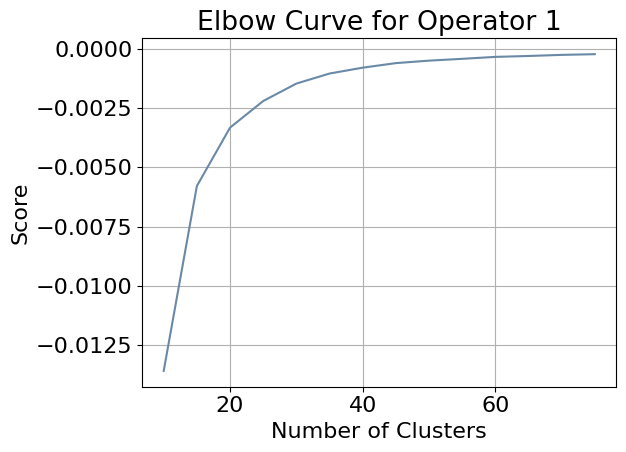

In [11]:
k_clusters = range(10, 80, 5)
kmeans = [KMeans(n_clusters=i) for i in k_clusters]

y_axis = df[['Latitude']]
X_axis = df[['Longitude']]

score = [kmeans[i].fit(y_axis).score(y_axis) for i in range(len(kmeans))]

fig = plt.figure()
plt.plot(k_clusters, score, color=rsrp_colors[1], zorder=2)
plt.grid(zorder=1)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve for Operator 1')
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/rf_loc/op1_elbow_curve.pdf')

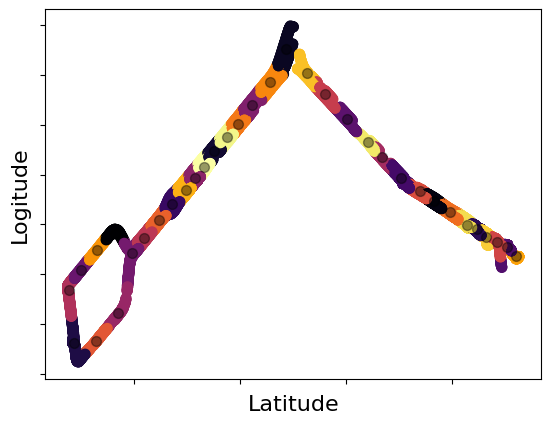

In [84]:
kmeans = KMeans(n_clusters=35, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op1_map_35_clusters_kmeans.pdf')

In [ ]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,4
1,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,4
2,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,4
3,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,4
4,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,4
...,...,...,...,...,...,...,...,...,...
11683,-101.59,7.44,-18.16,-100.2,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,4
11684,-101.59,7.44,-18.16,-100.2,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,4
11685,-101.59,7.44,-18.16,-99.4,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,4
11686,-101.59,7.44,-18.16,-99.4,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,4


In [86]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

## LSTM

### 1 step ahead

In [87]:
units = [10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [88]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [89]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00254,0.00330,2.11,2.11
1,"RSRP, SINR -> RSRP",0.00265,0.00336,1.93,2.02
2,"RSRP, RSRQ -> RSRP",0.00239,0.00100,0.64,0.76
3,"RSRP, SINR, RSRQ -> RSRP",0.00232,0.00303,1.94,2.01
4,"RSRP, SSS_RSRP -> RSRP",0.00239,0.00173,1.35,1.41
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00271,0.00152,1.43,1.40
6,SINR -> SINR,0.00193,0.00208,1.06,1.52
7,"RSRP, SINR -> SINR",0.00199,0.00244,1.34,1.87
8,"SINR, RSRQ -> SINR",0.00198,0.00165,0.99,1.29
9,"RSRP, SINR, RSRQ -> SINR",0.00234,0.00188,0.92,1.38


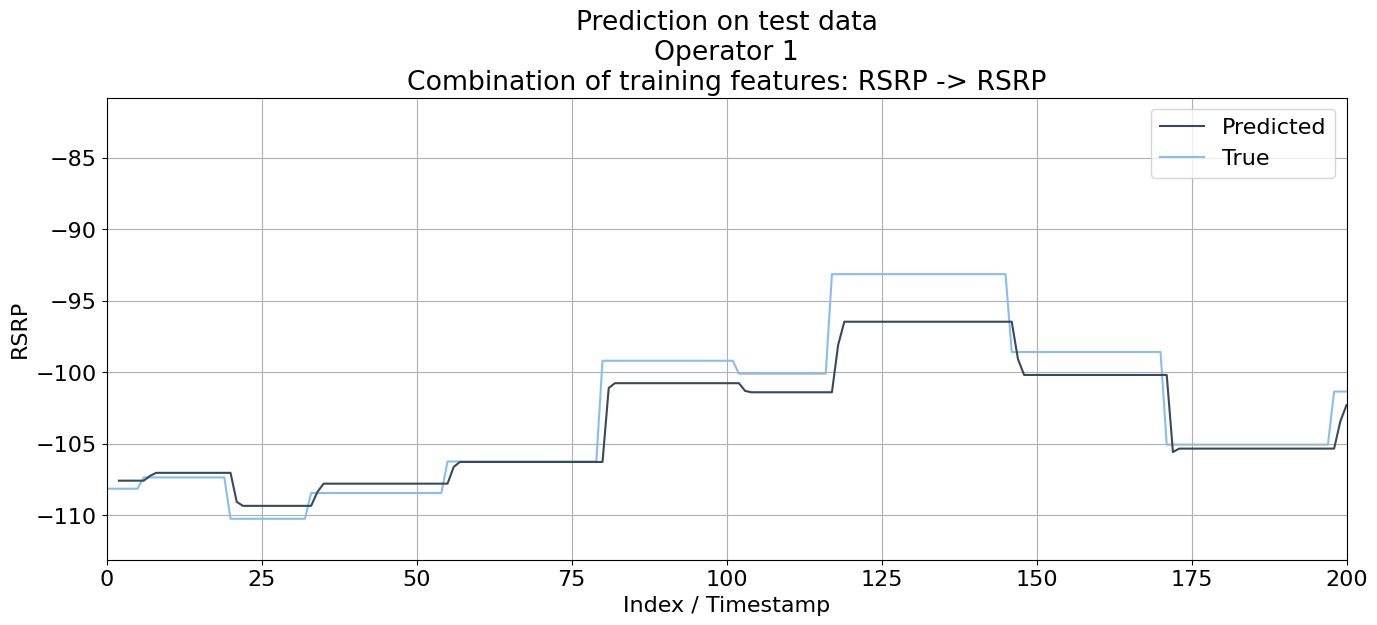

In [90]:
selected_rsrp_comb = 'RSRP -> RSRP'
rsrp_comb = lstm_results_1_step[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred_plot']
rsrp_true = rsrp_comb['y_true_plot']
rsrp_train_pred = rsrp_comb['train_pred_plot']
rsrp_train_true = rsrp_comb['train_true_plot']

fig = plot_lstm_1_step(pred=rsrp_pred, true=rsrp_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='test')

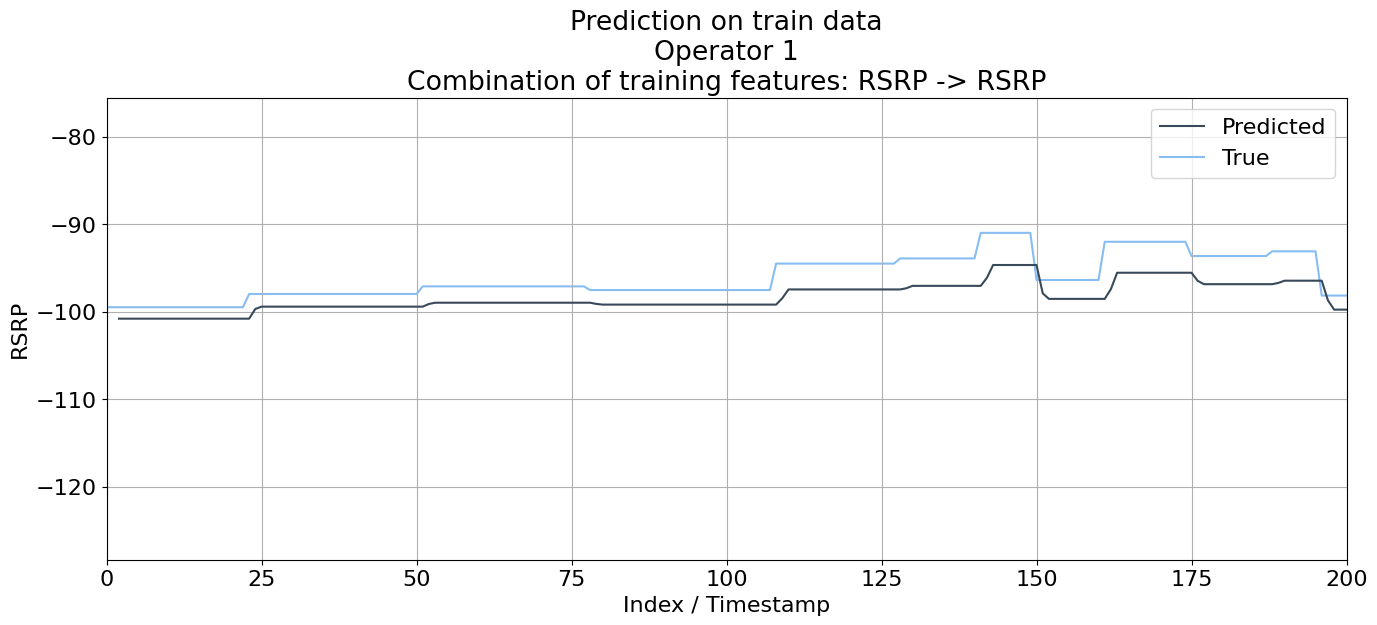

In [91]:
fig = plot_lstm_1_step(pred=rsrp_train_pred, true=rsrp_train_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='train')

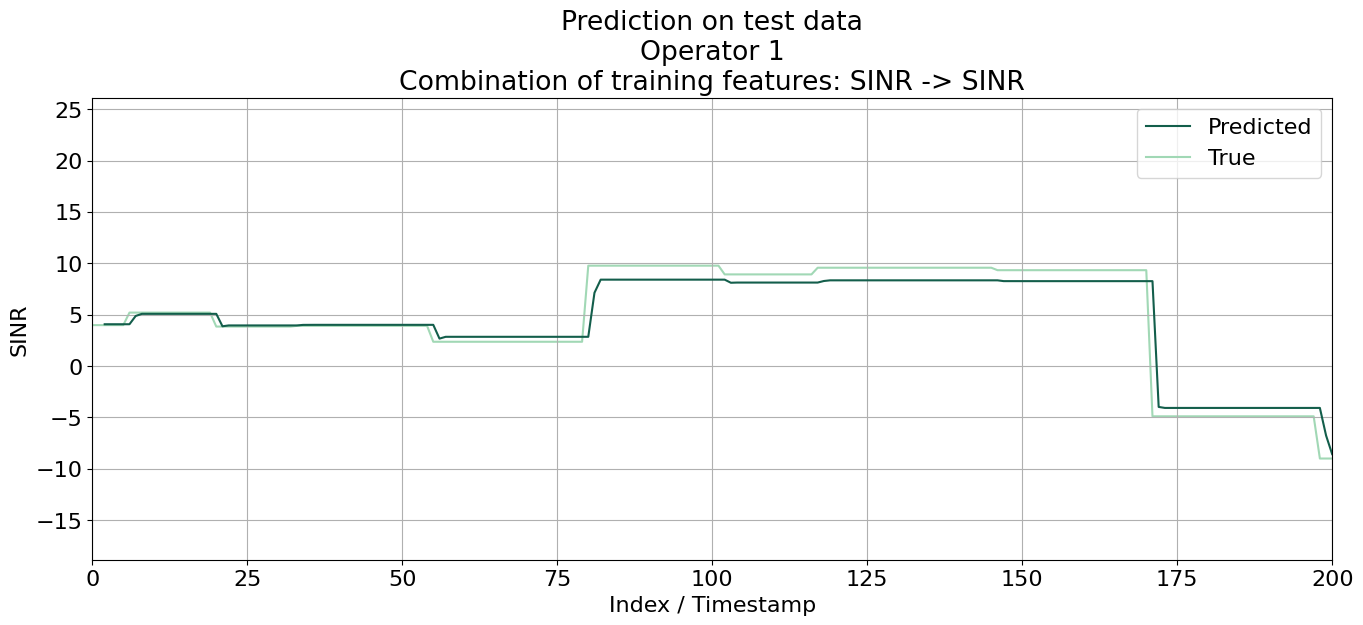

In [92]:
selected_sinr_comb = 'SINR -> SINR'
sinr_comb = lstm_results_1_step[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred_plot']
sinr_true = sinr_comb['y_true_plot']
sinr_train_pred = sinr_comb['train_pred_plot']
sinr_train_true = sinr_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sinr_pred, true=sinr_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='test')

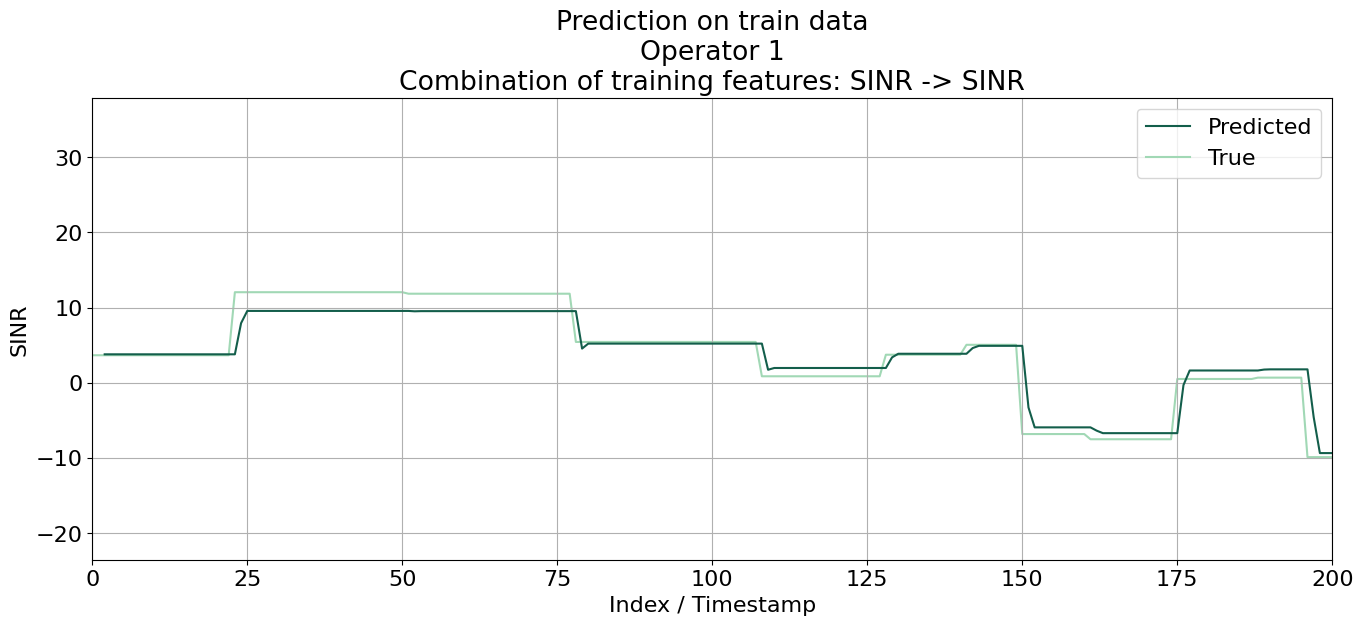

In [93]:
fig = plot_lstm_1_step(pred=sinr_train_pred, true=sinr_train_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='train')

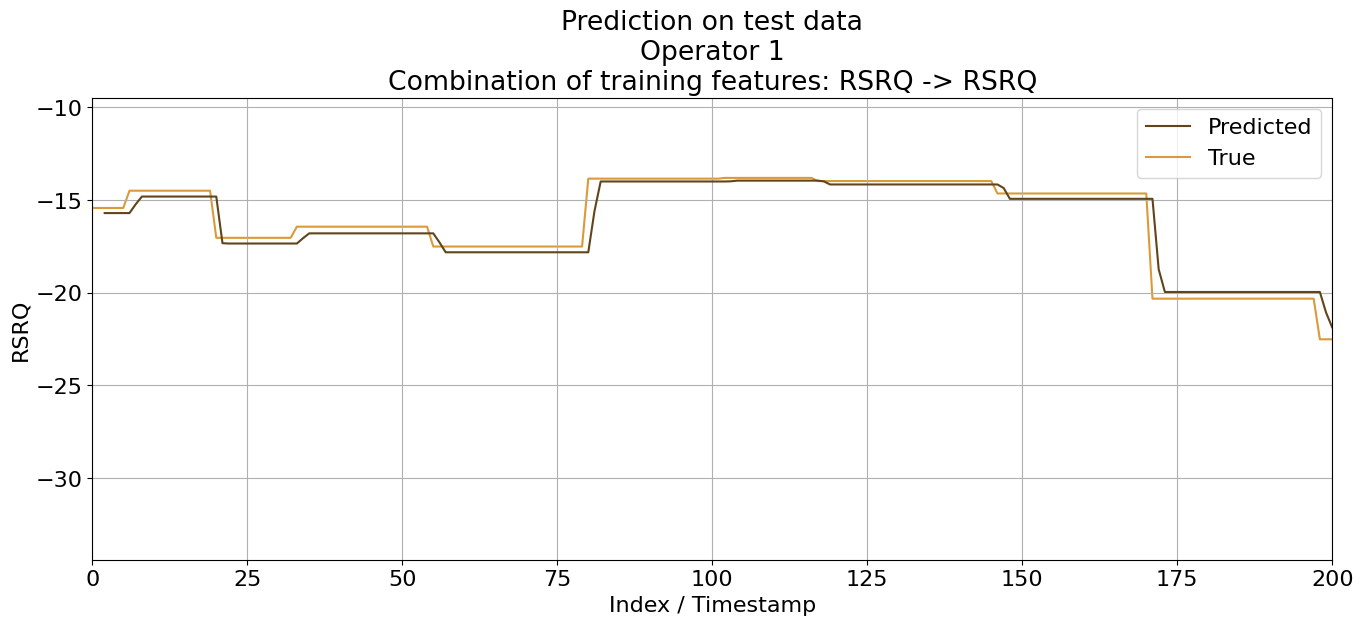

In [94]:
selected_rsrq_comb = 'RSRQ -> RSRQ'
rsrq_comb = lstm_results_1_step[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred_plot']
rsrq_true = rsrq_comb['y_true_plot']
rsrq_train_pred = rsrq_comb['train_pred_plot']
rsrq_train_true = rsrq_comb['train_true_plot']

fig = plot_lstm_1_step(pred=rsrq_pred, true=rsrq_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='test')

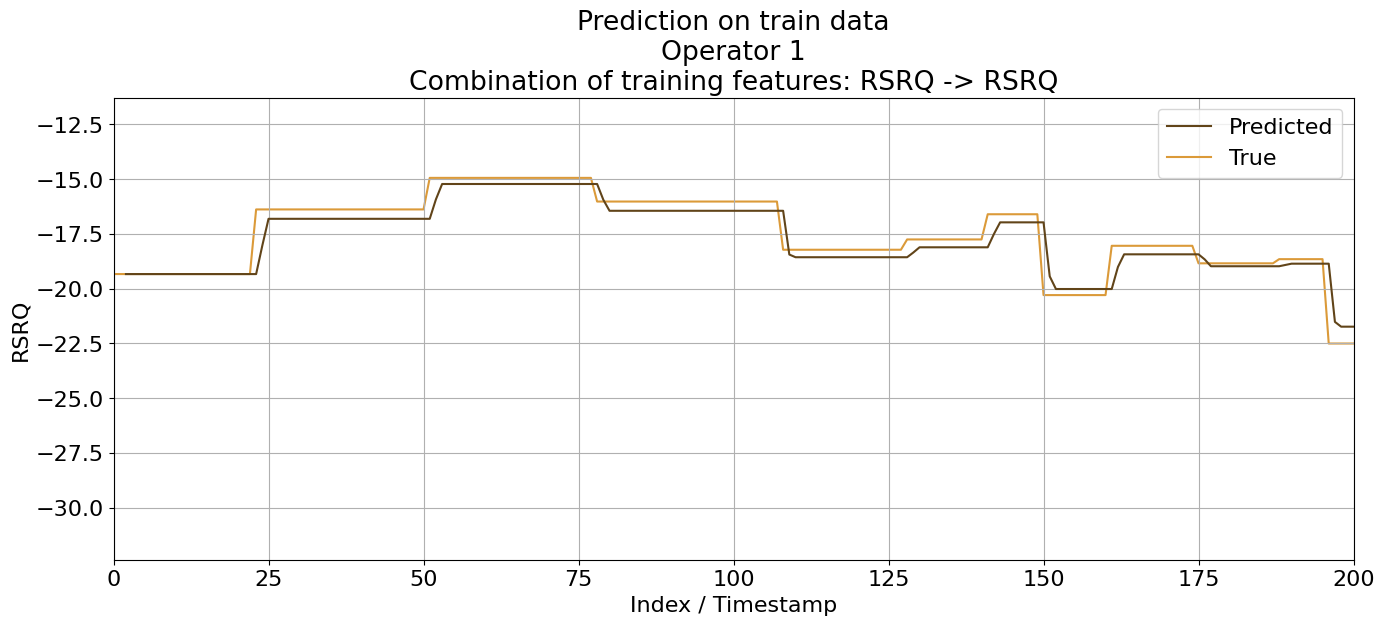

In [95]:
fig = plot_lstm_1_step(pred=rsrq_train_pred, true=rsrq_train_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='train')

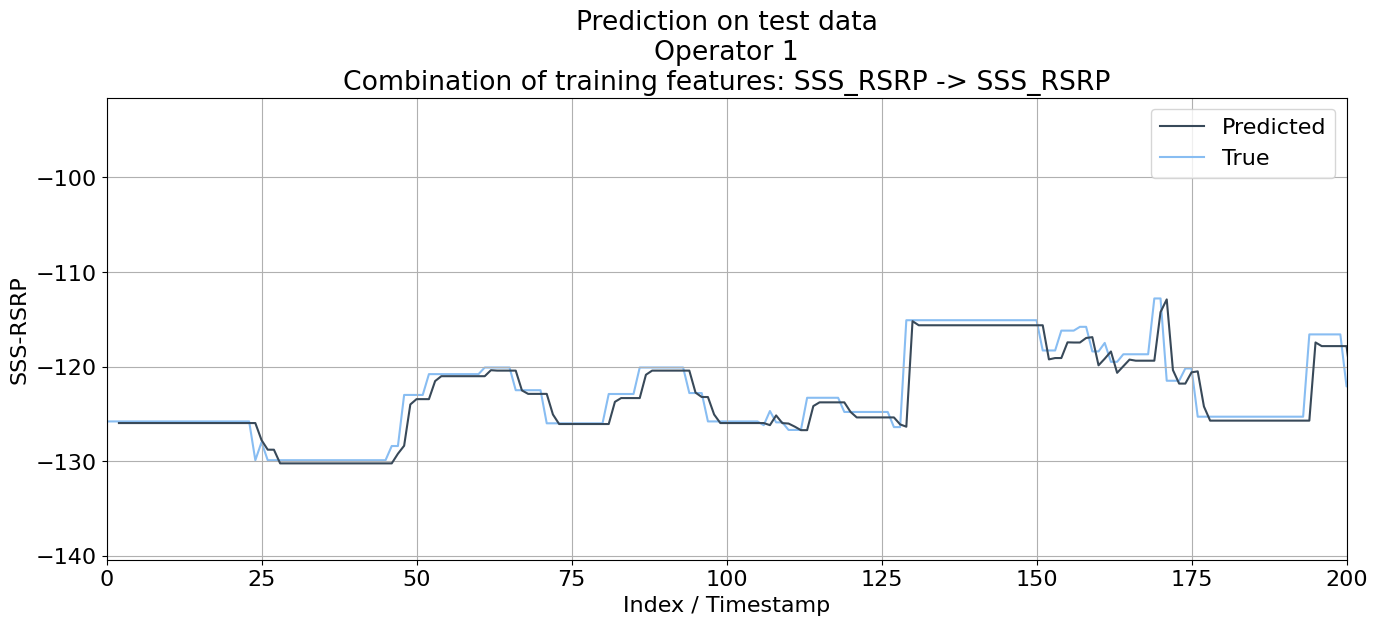

In [96]:
selected_sss_rsrp_comb = 'SSS_RSRP -> SSS_RSRP'
sss_rsrp_comb = lstm_results_1_step[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred_plot']
sss_rsrp_true = sss_rsrp_comb['y_true_plot']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred_plot']
sss_rsrp_train_true = sss_rsrp_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_rsrp_pred, true=sss_rsrp_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='test')

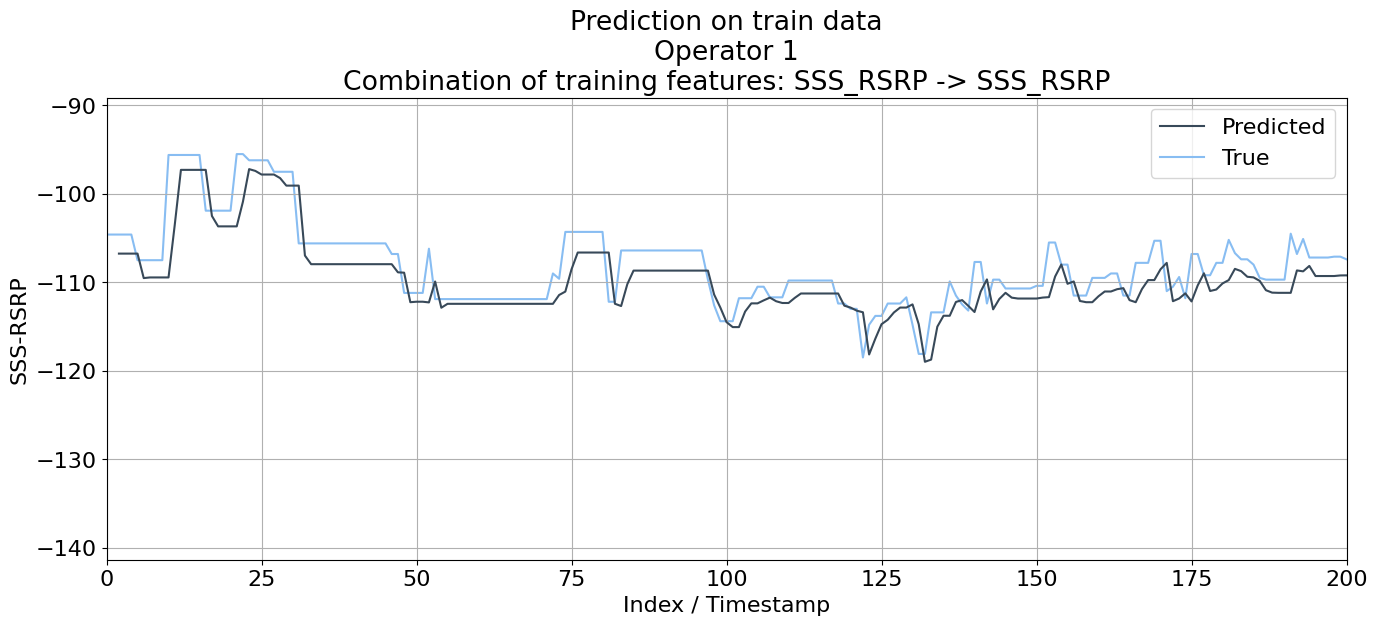

In [97]:
fig = plot_lstm_1_step(pred=sss_rsrp_train_pred, true=sss_rsrp_train_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='train')

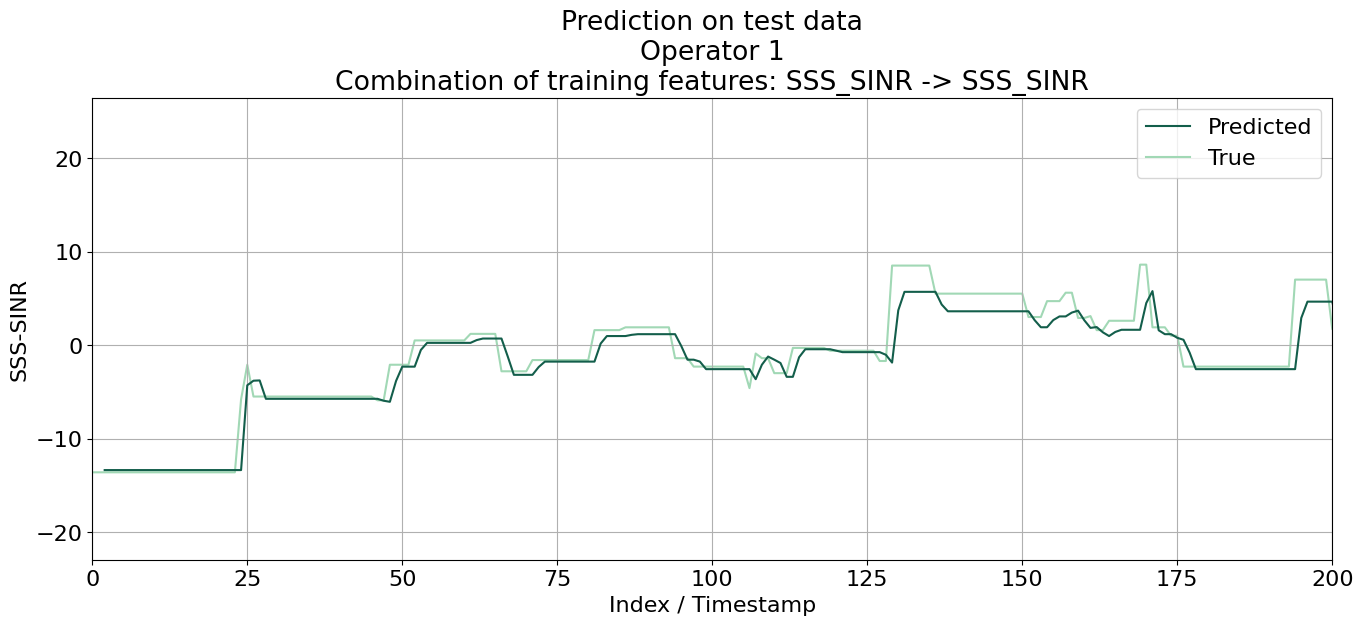

In [98]:
selected_sss_sinr_comb = 'SSS_SINR -> SSS_SINR'
sss_sinr_comb = lstm_results_1_step[selected_sss_sinr_comb]
sss_sinr_pred = sss_sinr_comb['y_pred_plot']
sss_sinr_true = sss_sinr_comb['y_true_plot']
sss_sinr_train_pred = sss_sinr_comb['train_pred_plot']
sss_sinr_train_true = sss_sinr_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_sinr_pred, true=sss_sinr_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='test')

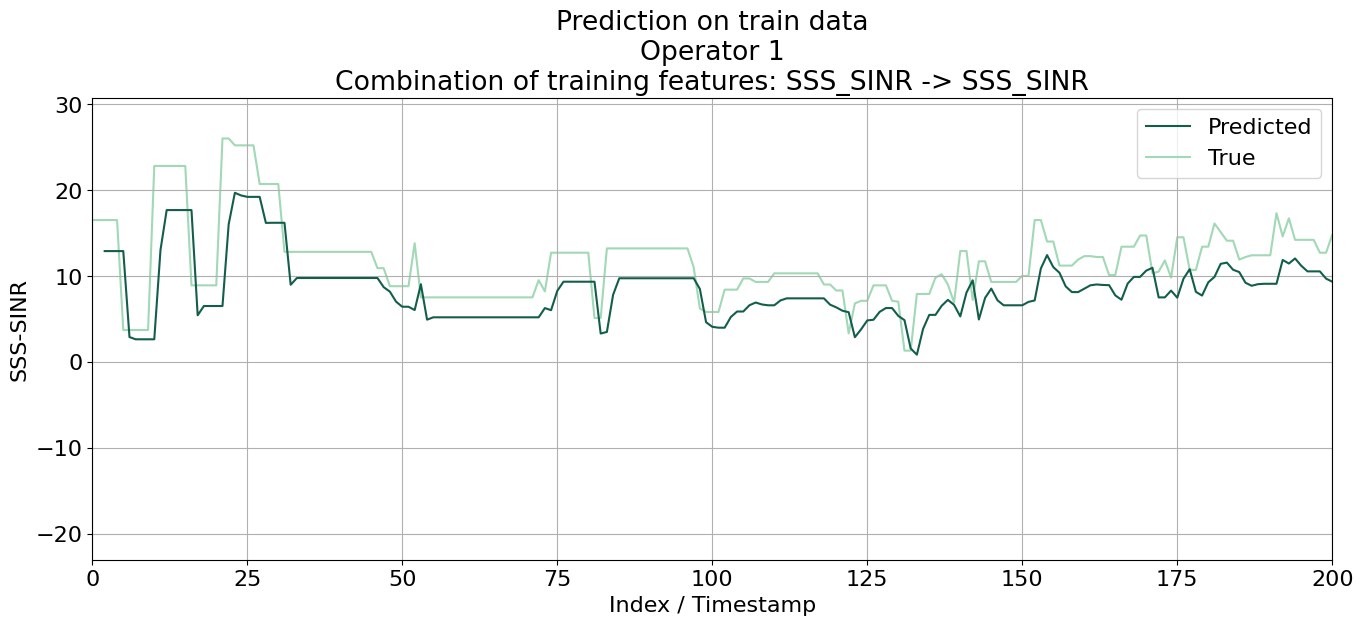

In [99]:
fig = plot_lstm_1_step(pred=sss_sinr_train_pred, true=sss_sinr_train_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='train')

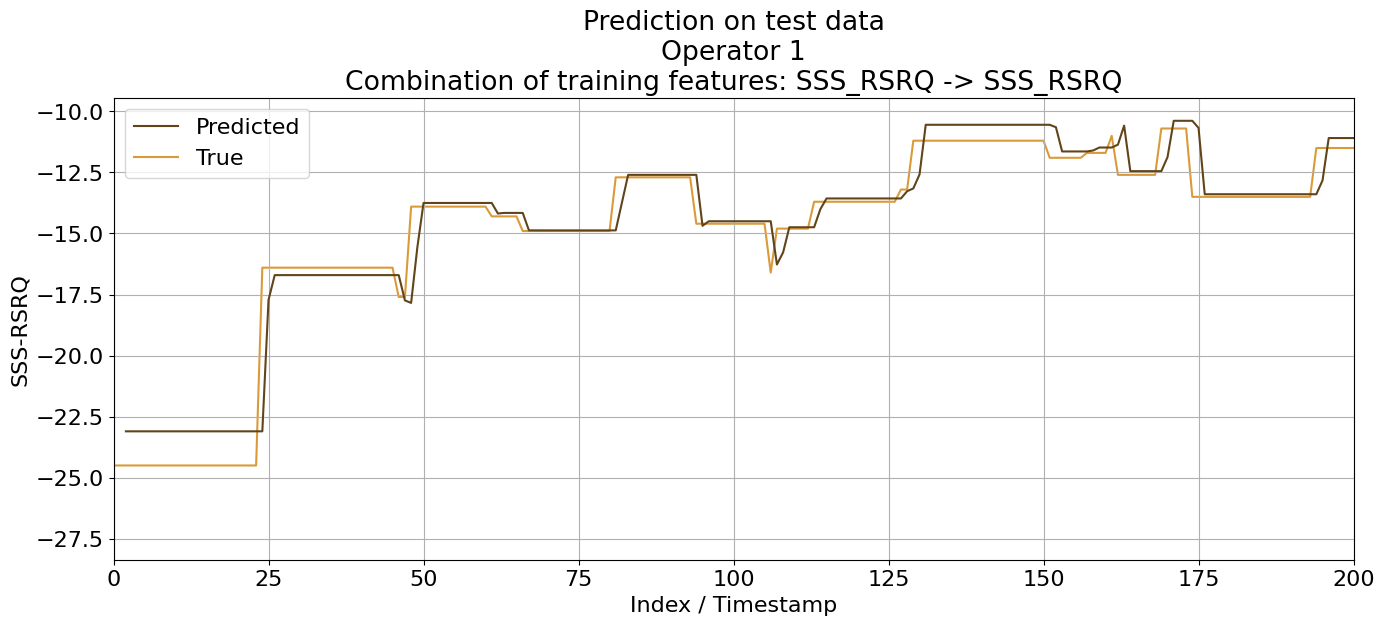

In [100]:
selected_sss_rsrq_comb = 'SSS_RSRQ -> SSS_RSRQ'
sss_rsrq_comb = lstm_results_1_step[selected_sss_rsrq_comb]
sss_rsrq_pred = sss_rsrq_comb['y_pred_plot']
sss_rsrq_true = sss_rsrq_comb['y_true_plot']
sss_rsrq_train_pred = sss_rsrq_comb['train_pred_plot']
sss_rsrq_train_true = sss_rsrq_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_rsrq_pred, true=sss_rsrq_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

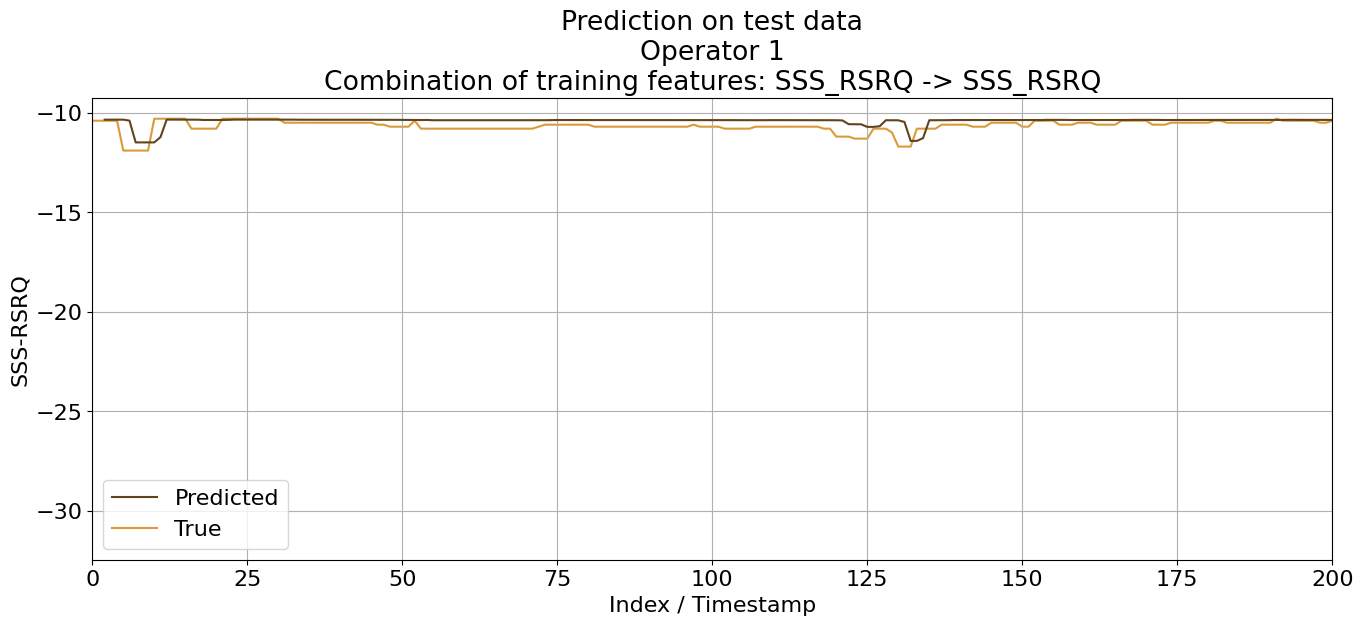

In [101]:
fig = plot_lstm_1_step(pred=sss_rsrq_train_pred, true=sss_rsrq_train_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

In [102]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [103]:
n_est, leaf = 50, 5

In [104]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]
warnings.simplefilter(action='ignore')
rf_results[f'n_est: {n_est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=n_est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 50, min_leaf: 5",0.646,0.831,0.272,0.995,0.981,0.995,0.654,0.357,0.745,0.934,0.906,0.822


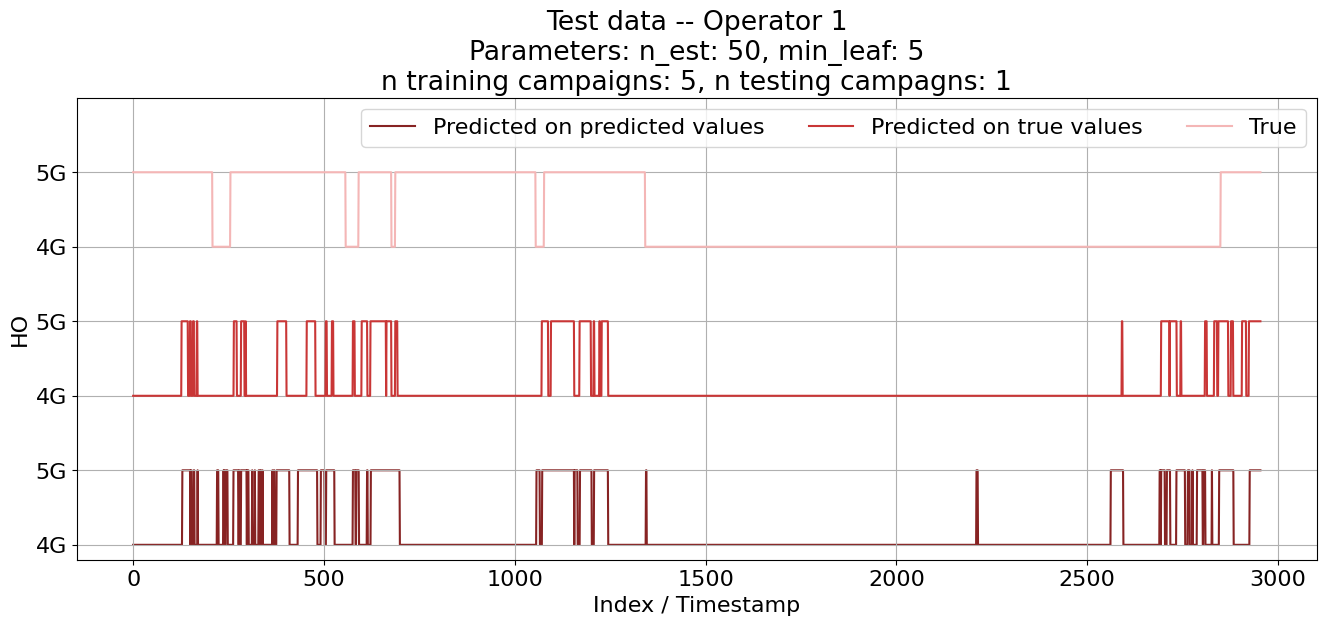

In [105]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

In [106]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [107]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 5, min_leaf: 1",0.623,0.746,0.251,0.998,0.992,0.997,0.646,0.330,0.742,0.919,0.870,0.792
1,"n_est: 5, min_leaf: 5",0.618,0.729,0.244,0.994,0.976,0.997,0.651,0.372,0.721,0.913,0.883,0.770
2,"n_est: 5, min_leaf: 10",0.628,0.722,0.288,0.987,0.955,0.988,0.658,0.407,0.713,0.898,0.895,0.721
3,"n_est: 5, min_leaf: 15",0.637,0.712,0.330,0.986,0.951,0.988,0.640,0.363,0.693,0.912,0.898,0.759
4,"n_est: 10, min_leaf: 1",0.620,0.738,0.245,0.998,0.994,0.997,0.598,0.252,0.639,0.917,0.875,0.783
5,"n_est: 10, min_leaf: 5",0.618,0.700,0.270,0.995,0.982,0.996,0.647,0.376,0.704,0.919,0.913,0.773
6,"n_est: 10, min_leaf: 10",0.642,0.741,0.317,0.990,0.965,0.993,0.671,0.367,0.793,0.924,0.909,0.788
7,"n_est: 10, min_leaf: 15",0.648,0.774,0.311,0.986,0.948,0.992,0.652,0.407,0.697,0.879,0.896,0.676
8,"n_est: 50, min_leaf: 1",0.631,0.760,0.268,0.998,0.994,0.997,0.614,0.287,0.668,0.934,0.904,0.823
9,"n_est: 50, min_leaf: 5",0.646,0.788,0.296,0.995,0.983,0.997,0.660,0.376,0.745,0.922,0.909,0.784


In [108]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.639
Mean precision: 0.771
Mean recall: 0.285


In [109]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [110]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00254,0.00330,2.11,2.11
1,"RSRP, SINR -> RSRP",0.00265,0.00336,1.93,2.02
2,"RSRP, RSRQ -> RSRP",0.00239,0.00100,0.64,0.76
3,"RSRP, SINR, RSRQ -> RSRP",0.00232,0.00303,1.94,2.01
4,"RSRP, SSS_RSRP -> RSRP",0.00239,0.00173,1.35,1.41
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00271,0.00152,1.43,1.40
6,SINR -> SINR,0.00193,0.00208,1.06,1.52
7,"RSRP, SINR -> SINR",0.00199,0.00244,1.34,1.87
8,"SINR, RSRQ -> SINR",0.00198,0.00165,0.99,1.29
9,"RSRP, SINR, RSRQ -> SINR",0.00234,0.00188,0.92,1.38


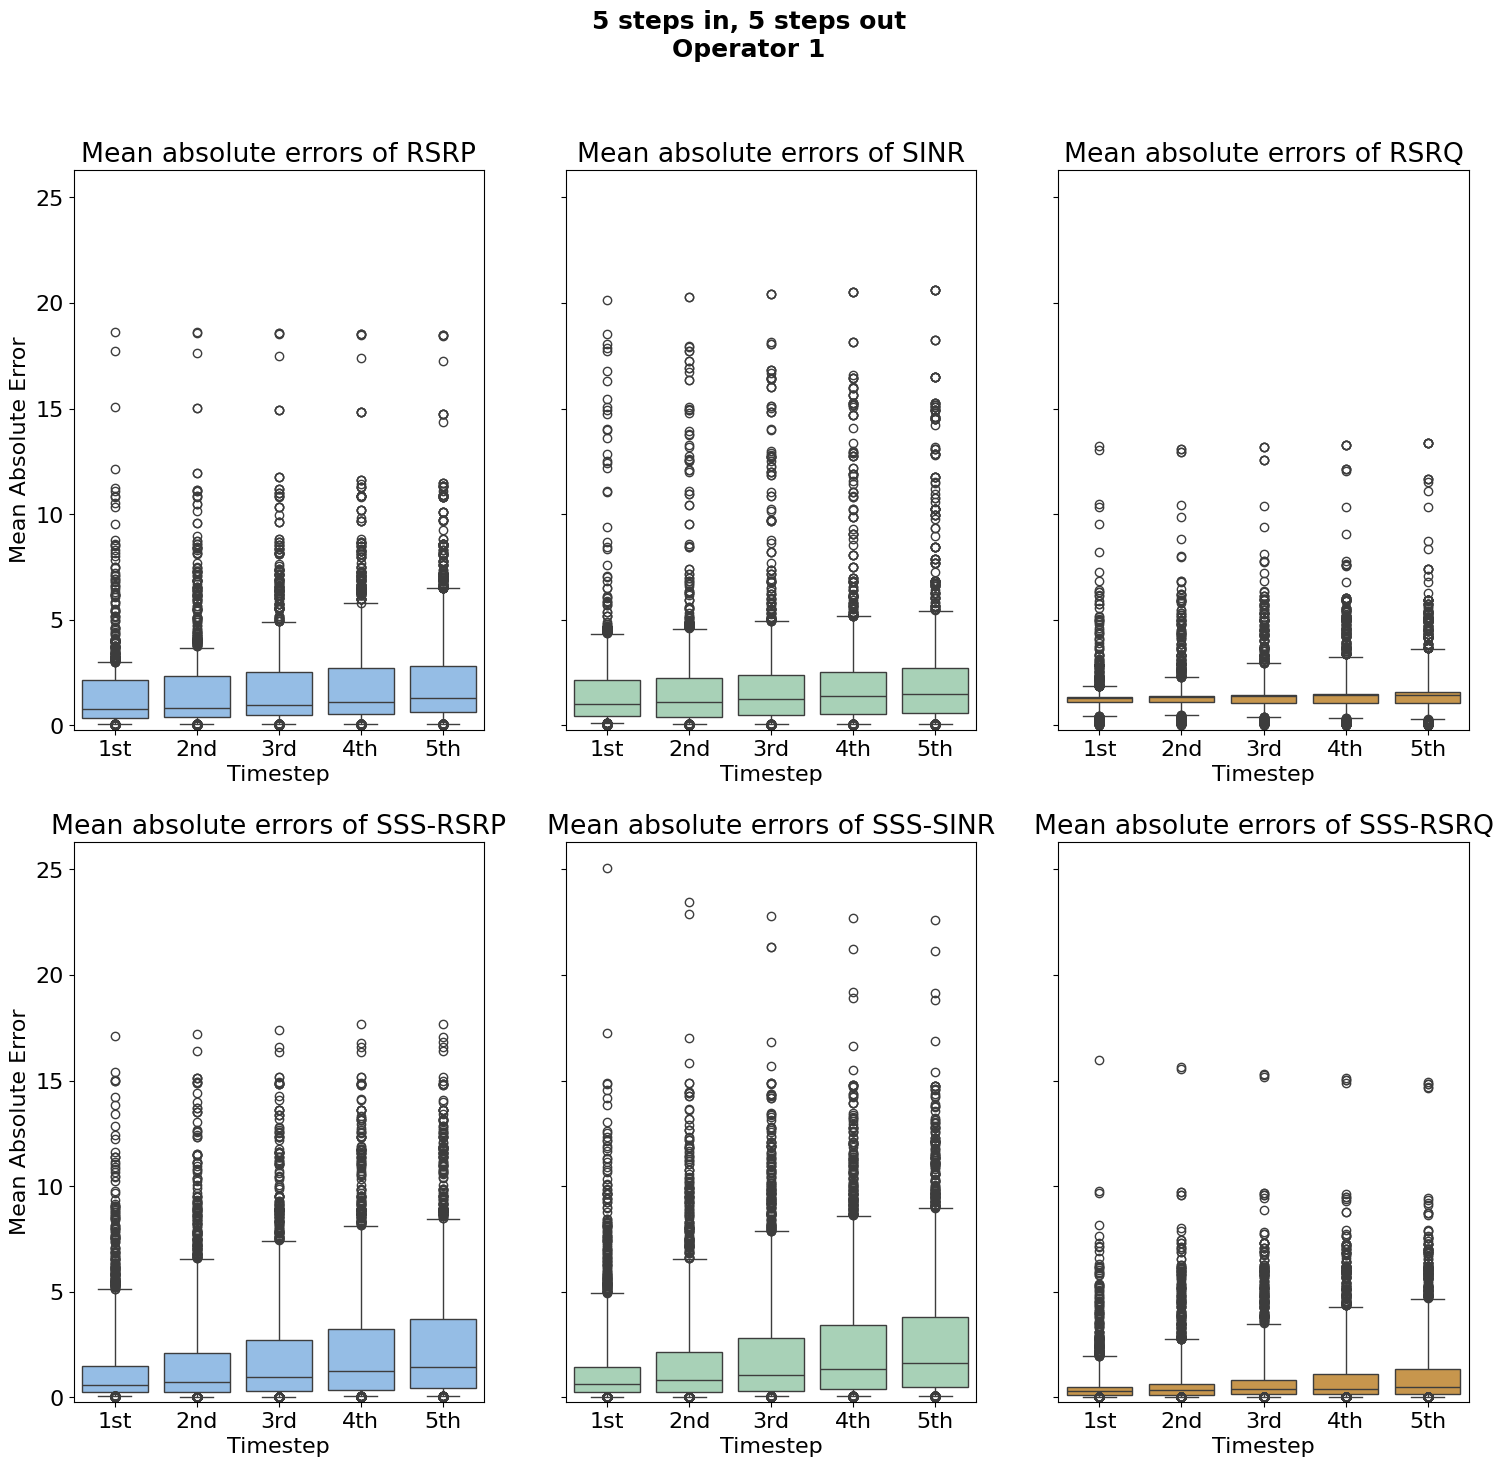

In [111]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op1_box_5_steps_mae_lstm_35_clusters.pdf')

In [112]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [113]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.610,0.697,0.236,0.998,0.993,0.997,0.618,0.241,0.728,0.910,0.816,0.793,"[0.6092265943012212, 0.6095658073270014, 0.609...","[0.9978125719548699, 0.9978125719548699, 0.997..."
1,"n_est: 5, min_leaf: 5",0.630,0.705,0.307,0.993,0.976,0.995,0.615,0.290,0.668,0.900,0.822,0.758,"[0.6295793758480326, 0.6299185888738128, 0.630...","[0.9934377158646097, 0.9934377158646097, 0.993..."
2,"n_est: 5, min_leaf: 10",0.668,0.756,0.387,0.984,0.944,0.988,0.672,0.378,0.780,0.896,0.816,0.748,"[0.6668928086838535, 0.6672320217096337, 0.667...","[0.9839972369329957, 0.9839972369329957, 0.983..."
3,"n_est: 5, min_leaf: 15",0.624,0.710,0.277,0.984,0.943,0.988,0.630,0.313,0.699,0.889,0.798,0.735,"[0.6234735413839891, 0.6234735413839891, 0.623...","[0.9836518535574488, 0.9837669813492977, 0.983..."
4,"n_est: 10, min_leaf: 1",0.594,0.702,0.172,0.998,0.993,0.997,0.634,0.282,0.747,0.908,0.799,0.795,"[0.5936227951153324, 0.5939620081411127, 0.594...","[0.9978125719548699, 0.9978125719548699, 0.997..."
5,"n_est: 10, min_leaf: 5",0.640,0.752,0.299,0.994,0.979,0.995,0.664,0.358,0.773,0.907,0.856,0.763,"[0.6394165535956581, 0.6397557666214383, 0.640...","[0.9941284826157034, 0.9941284826157034, 0.994..."
6,"n_est: 10, min_leaf: 10",0.621,0.715,0.261,0.989,0.957,0.995,0.651,0.337,0.750,0.900,0.864,0.737,"[0.6200814111261872, 0.6204206241519674, 0.620...","[0.9887174763988027, 0.9887174763988027, 0.988..."
7,"n_est: 10, min_leaf: 15",0.674,0.794,0.372,0.984,0.946,0.987,0.694,0.445,0.782,0.888,0.833,0.718,"[0.673337856173677, 0.6736770691994572, 0.6740...","[0.9841123647248445, 0.9842274925166935, 0.984..."
8,"n_est: 50, min_leaf: 1",0.640,0.811,0.262,0.998,0.994,0.997,0.646,0.307,0.766,0.929,0.828,0.852,"[0.6397557666214383, 0.6400949796472184, 0.640...","[0.9979276997467189, 0.9979276997467189, 0.997..."
9,"n_est: 50, min_leaf: 5",0.647,0.780,0.301,0.995,0.982,0.997,0.663,0.359,0.771,0.908,0.839,0.773,"[0.6465400271370421, 0.6468792401628223, 0.647...","[0.995279760534193, 0.995279760534193, 0.99527..."


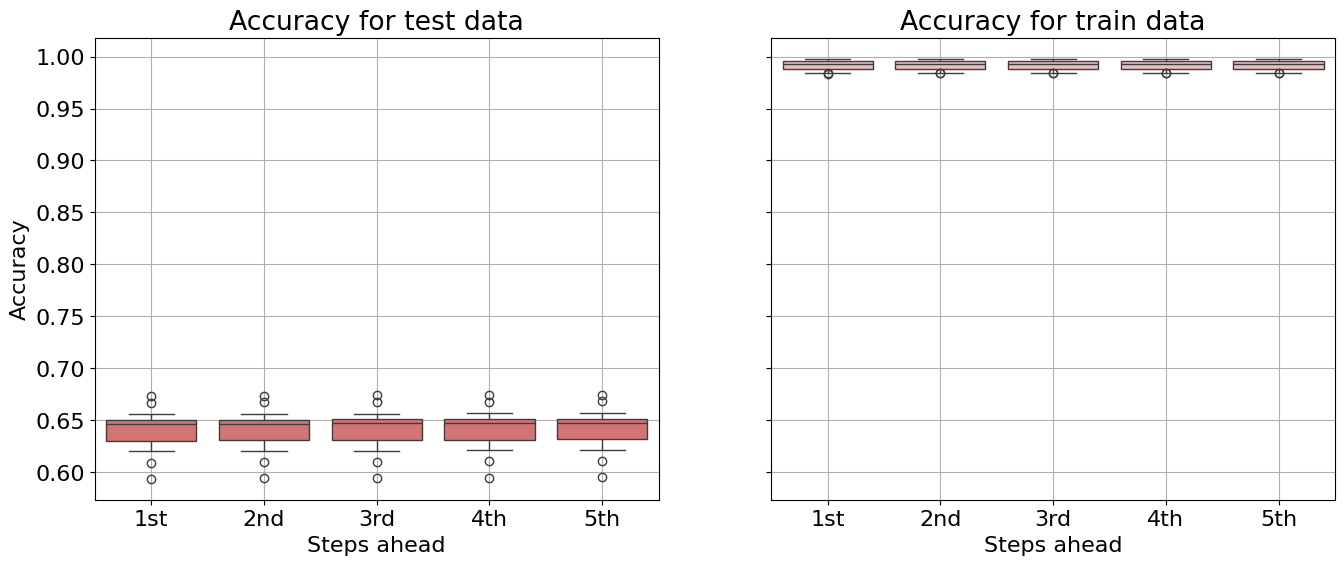

In [114]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/rf_loc/op1_boxplot_5_steps_35_clusters.pdf')

## 20 clusters

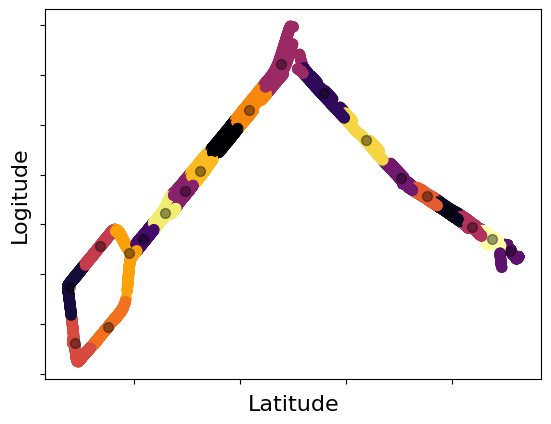

In [115]:
kmeans = KMeans(n_clusters=20, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op1_map_20_clusters_kmeans.pdf')

In [116]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,11
1,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,11
2,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,11
3,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,11
4,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,11
...,...,...,...,...,...,...,...,...,...
11683,-101.59,7.44,-18.16,-100.2,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,11
11684,-101.59,7.44,-18.16,-100.2,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,11
11685,-101.59,7.44,-18.16,-99.4,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,11
11686,-101.59,7.44,-18.16,-99.4,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,11


In [117]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

### LSTM

#### 1 step ahead

In [118]:
units = [5, 10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [119]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [120]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00281,0.00258,1.40,1.58
1,"RSRP, SINR -> RSRP",0.00410,0.00565,3.02,3.01
2,"RSRP, RSRQ -> RSRP",0.00322,0.00277,1.49,1.67
3,"RSRP, SINR, RSRQ -> RSRP",0.00295,0.00213,1.18,1.44
4,"RSRP, SSS_RSRP -> RSRP",0.00300,0.00491,2.29,2.55
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00327,0.00302,1.57,1.89
6,SINR -> SINR,0.00499,0.00424,1.66,2.47
7,"RSRP, SINR -> SINR",0.00341,0.00301,1.67,2.25
8,"SINR, RSRQ -> SINR",0.00224,0.00279,1.63,2.18
9,"RSRP, SINR, RSRQ -> SINR",0.00307,0.00401,2.13,2.79


In [121]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

### Random Forest

In [122]:
n_est, leaf = 50, 5

In [123]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]
warnings.simplefilter(action='ignore')
rf_results[f'n_est: {n_est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=n_est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 50, min_leaf: 5",0.633,0.8,0.249,0.994,0.981,0.995,0.606,0.182,0.767,0.884,0.675,0.782,[],[]


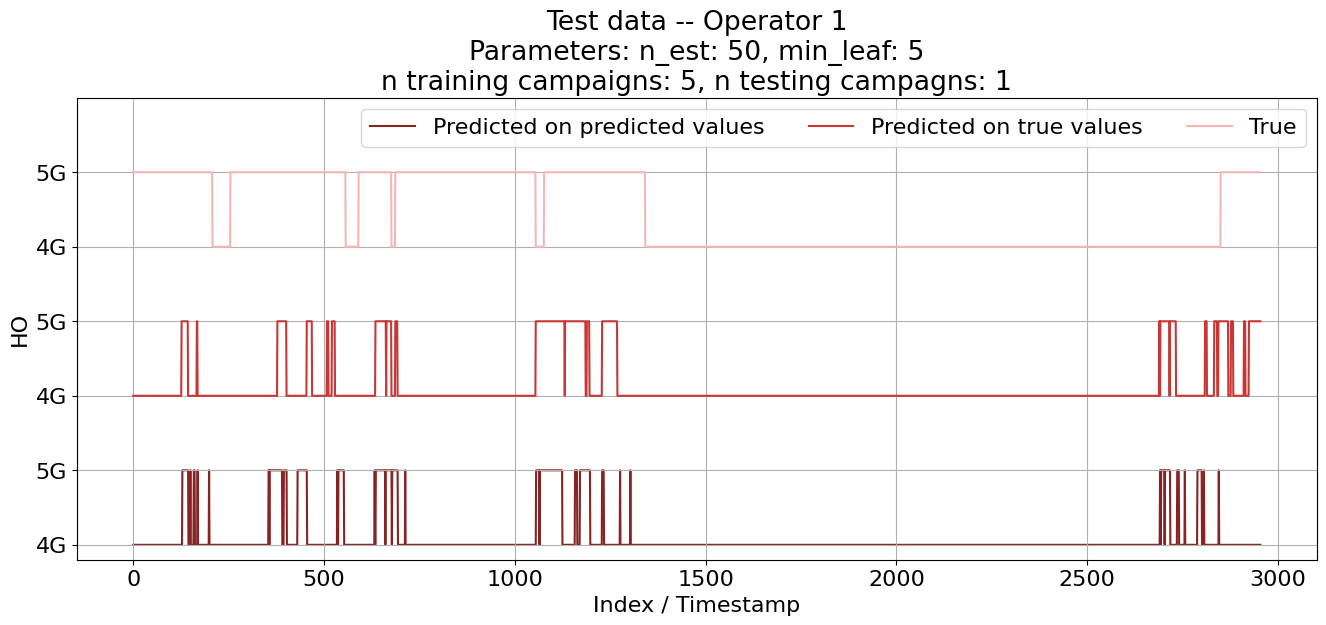

In [124]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

In [125]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [126]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.607,0.678,0.249,0.998,0.994,0.996,0.596,0.156,0.751,0.866,0.656,0.728,[],[]
1,"n_est: 5, min_leaf: 5",0.623,0.731,0.260,0.992,0.971,0.995,0.639,0.252,0.828,0.879,0.658,0.777,[],[]
2,"n_est: 5, min_leaf: 10",0.663,0.802,0.337,0.985,0.949,0.987,0.660,0.322,0.810,0.860,0.689,0.693,[],[]
3,"n_est: 5, min_leaf: 15",0.654,0.786,0.320,0.983,0.939,0.992,0.629,0.262,0.756,0.874,0.714,0.725,[],[]
4,"n_est: 10, min_leaf: 1",0.626,0.797,0.230,0.998,0.994,0.997,0.581,0.105,0.765,0.894,0.670,0.831,[],[]
5,"n_est: 10, min_leaf: 5",0.638,0.780,0.277,0.994,0.980,0.996,0.623,0.214,0.817,0.887,0.698,0.781,[],[]
6,"n_est: 10, min_leaf: 10",0.628,0.815,0.227,0.988,0.960,0.989,0.634,0.226,0.858,0.881,0.691,0.761,[],[]
7,"n_est: 10, min_leaf: 15",0.670,0.830,0.337,0.983,0.938,0.989,0.663,0.299,0.869,0.880,0.666,0.775,[],[]
8,"n_est: 50, min_leaf: 1",0.615,0.776,0.208,0.998,0.994,0.997,0.602,0.141,0.866,0.886,0.651,0.812,[],[]
9,"n_est: 50, min_leaf: 5",0.631,0.797,0.247,0.995,0.981,0.996,0.599,0.154,0.786,0.886,0.679,0.790,[],[]


In [127]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.631
Mean precision: 0.783
Mean recall: 0.252


#### 5 steps ahead

In [128]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [129]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00281,0.00258,1.40,1.58
1,"RSRP, SINR -> RSRP",0.00410,0.00565,3.02,3.01
2,"RSRP, RSRQ -> RSRP",0.00322,0.00277,1.49,1.67
3,"RSRP, SINR, RSRQ -> RSRP",0.00295,0.00213,1.18,1.44
4,"RSRP, SSS_RSRP -> RSRP",0.00300,0.00491,2.29,2.55
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00327,0.00302,1.57,1.89
6,SINR -> SINR,0.00499,0.00424,1.66,2.47
7,"RSRP, SINR -> SINR",0.00341,0.00301,1.67,2.25
8,"SINR, RSRQ -> SINR",0.00224,0.00279,1.63,2.18
9,"RSRP, SINR, RSRQ -> SINR",0.00307,0.00401,2.13,2.79


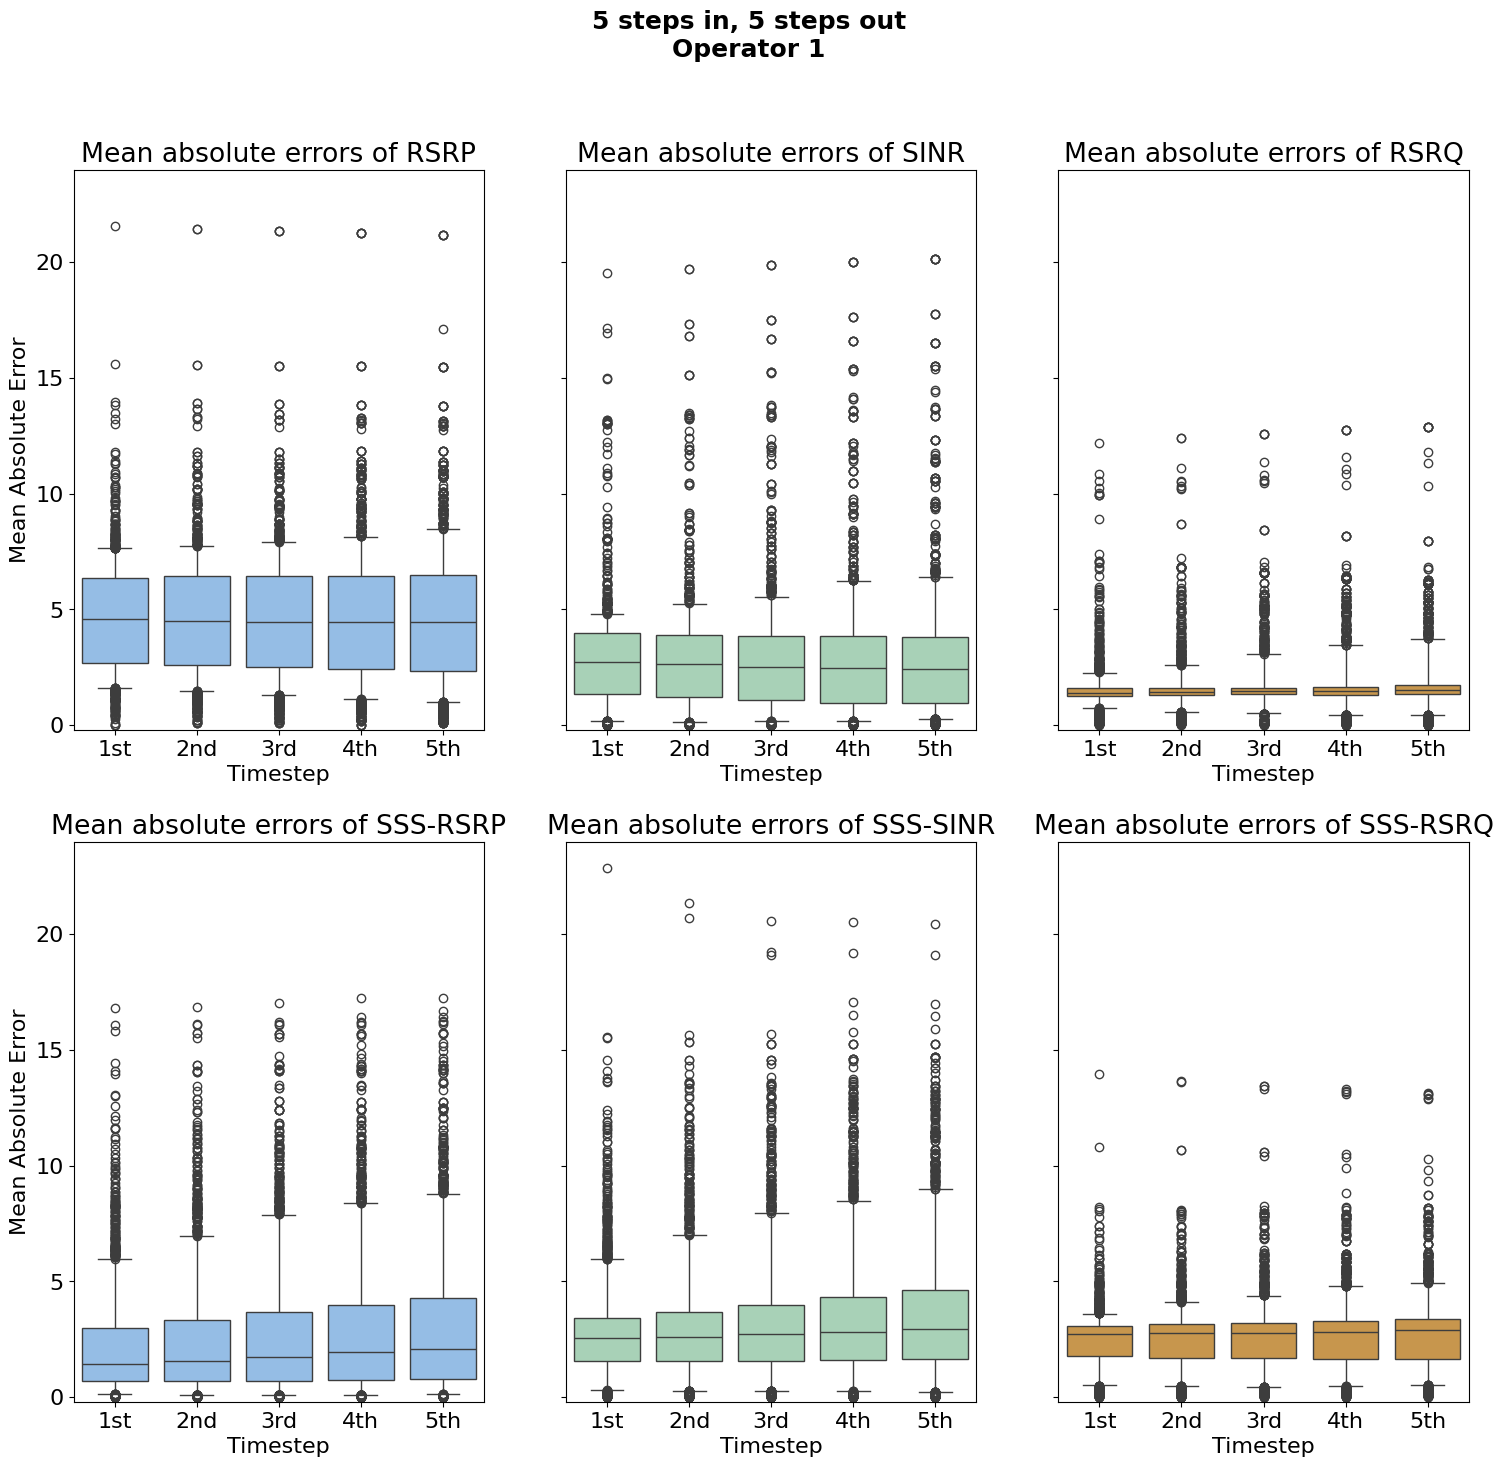

In [130]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op1_box_5_steps_mae_lstm_20_clusters.pdf')

In [131]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [132]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.596,0.740,0.159,0.998,0.994,0.996,0.583,0.087,0.866,0.850,0.486,0.765,"[0.5956580732700135, 0.5959972862957937, 0.596...","[0.9978125719548699, 0.9978125719548699, 0.997..."
1,"n_est: 5, min_leaf: 5",0.613,0.685,0.258,0.994,0.978,0.996,0.577,0.127,0.658,0.835,0.456,0.712,"[0.6119402985074627, 0.6122795115332429, 0.612...","[0.9941284826157034, 0.9941284826157034, 0.994..."
2,"n_est: 5, min_leaf: 10",0.660,0.738,0.380,0.986,0.946,0.996,0.568,0.074,0.690,0.823,0.336,0.736,"[0.6594301221166893, 0.6597693351424695, 0.660...","[0.9861846649781257, 0.9861846649781257, 0.986..."
3,"n_est: 5, min_leaf: 15",0.645,0.790,0.287,0.979,0.921,0.994,0.585,0.115,0.754,0.822,0.405,0.678,"[0.6441655359565808, 0.6445047489823609, 0.644...","[0.9793921252590375, 0.9793921252590375, 0.979..."
4,"n_est: 10, min_leaf: 1",0.652,0.770,0.323,0.998,0.994,0.997,0.565,0.039,0.865,0.802,0.181,0.762,"[0.6509497964721845, 0.6512890094979648, 0.651...","[0.9980428275385678, 0.9980428275385678, 0.998..."
5,"n_est: 10, min_leaf: 5",0.609,0.749,0.198,0.995,0.982,0.994,0.556,0.018,0.819,0.798,0.166,0.739,"[0.6092265943012212, 0.6092265943012212, 0.609...","[0.9945889937830993, 0.9945889937830993, 0.994..."
6,"n_est: 10, min_leaf: 10",0.642,0.794,0.278,0.987,0.953,0.991,0.561,0.024,0.982,0.795,0.163,0.699,"[0.6417910447761194, 0.6421302578018996, 0.642...","[0.9869905595210684, 0.9869905595210684, 0.986..."
7,"n_est: 10, min_leaf: 15",0.649,0.807,0.290,0.984,0.940,0.992,0.554,0.015,0.724,0.828,0.345,0.765,"[0.6485753052917232, 0.6489145183175034, 0.649...","[0.9838821091411467, 0.9838821091411467, 0.983..."
8,"n_est: 50, min_leaf: 1",0.610,0.742,0.203,0.998,0.994,0.997,0.571,0.051,0.918,0.840,0.397,0.794,"[0.608887381275441, 0.6092265943012212, 0.6095...","[0.9980428275385678, 0.9980428275385678, 0.998..."
9,"n_est: 50, min_leaf: 5",0.621,0.776,0.222,0.994,0.977,0.996,0.557,0.017,1.000,0.846,0.370,0.877,"[0.6200814111261872, 0.6204206241519674, 0.620...","[0.9937830992401566, 0.9937830992401566, 0.993..."


In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

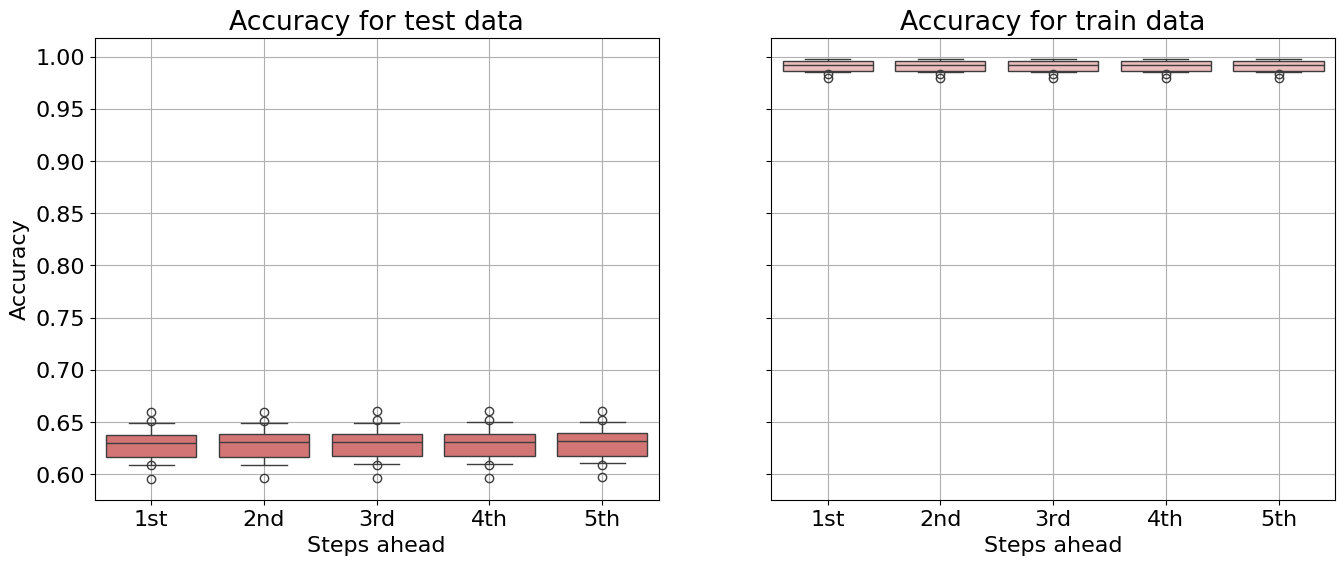

In [133]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op1_boxplot_5_steps_20_clusters.pdf')

## 60 clusters

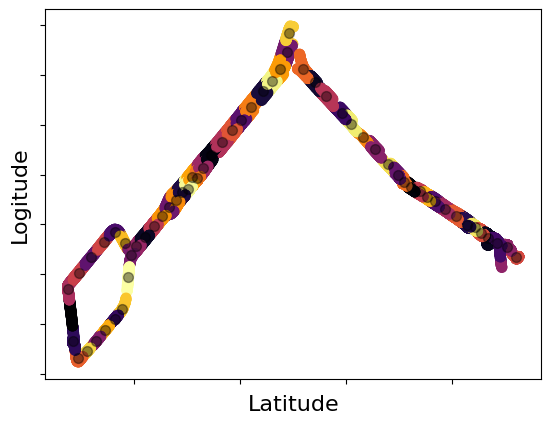

In [134]:
kmeans = KMeans(n_clusters=60, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op1_map_60_clusters_kmeans.pdf')

In [135]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,9
1,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,9
2,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,9
3,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,9
4,-99.49,3.65,-19.34,-104.6,16.5,-10.4,Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...,0,9
...,...,...,...,...,...,...,...,...,...
11683,-101.59,7.44,-18.16,-100.2,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,9
11684,-101.59,7.44,-18.16,-100.2,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,9
11685,-101.59,7.44,-18.16,-99.4,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,9
11686,-101.59,7.44,-18.16,-99.4,17.3,-10.3,Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_...,0,9


In [136]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

### LSTM

#### 1 step ahead

In [137]:
units = [5, 10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [138]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00636,0.00320,1.82,2.13
1,"RSRP, SINR, RSRQ -> RSRP",0.00340,0.00276,1.31,1.79
2,"RSRP, SSS_RSRP -> RSRP",0.00322,0.00172,0.87,1.17
3,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00344,0.01171,4.82,4.61
4,SINR -> SINR,0.00337,0.00420,2.01,2.75
5,"RSRP, SINR, RSRQ -> SINR",0.00310,0.00570,2.77,3.59
6,"SINR, SSS_SINR -> SINR",0.00231,0.00296,1.84,2.32
7,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00230,0.00310,1.79,2.26
8,RSRQ -> RSRQ,0.00759,0.00527,0.49,0.63
9,"RSRP, SINR, RSRQ -> RSRQ",0.00863,0.00865,1.38,1.45


In [139]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [140]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [141]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.642,0.807,0.273,0.998,0.994,0.996,0.609,0.289,0.651,0.878,0.877,0.680,[],[]
1,"n_est: 5, min_leaf: 5",0.632,0.784,0.256,0.993,0.976,0.993,0.674,0.340,0.845,0.904,0.795,0.787,[],[]
2,"n_est: 5, min_leaf: 10",0.644,0.851,0.257,0.987,0.953,0.991,0.616,0.269,0.693,0.905,0.866,0.752,[],[]
3,"n_est: 5, min_leaf: 15",0.652,0.781,0.320,0.984,0.947,0.987,0.659,0.372,0.744,0.880,0.870,0.686,[],[]
4,"n_est: 10, min_leaf: 1",0.629,0.781,0.247,0.998,0.993,0.997,0.639,0.274,0.787,0.903,0.888,0.737,[],[]
5,"n_est: 10, min_leaf: 5",0.624,0.888,0.190,0.996,0.986,0.994,0.632,0.232,0.831,0.931,0.893,0.819,[],[]
6,"n_est: 10, min_leaf: 10",0.634,0.807,0.248,0.989,0.956,0.995,0.649,0.314,0.776,0.908,0.911,0.744,[],[]
7,"n_est: 10, min_leaf: 15",0.644,0.797,0.283,0.987,0.952,0.991,0.615,0.271,0.688,0.928,0.896,0.810,[],[]
8,"n_est: 50, min_leaf: 1",0.622,0.868,0.193,0.998,0.994,0.997,0.631,0.235,0.816,0.917,0.891,0.777,[],[]
9,"n_est: 50, min_leaf: 5",0.640,0.873,0.237,0.996,0.985,0.996,0.653,0.284,0.844,0.933,0.924,0.809,[],[]


In [142]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.632
Mean precision: 0.829
Mean recall: 0.234


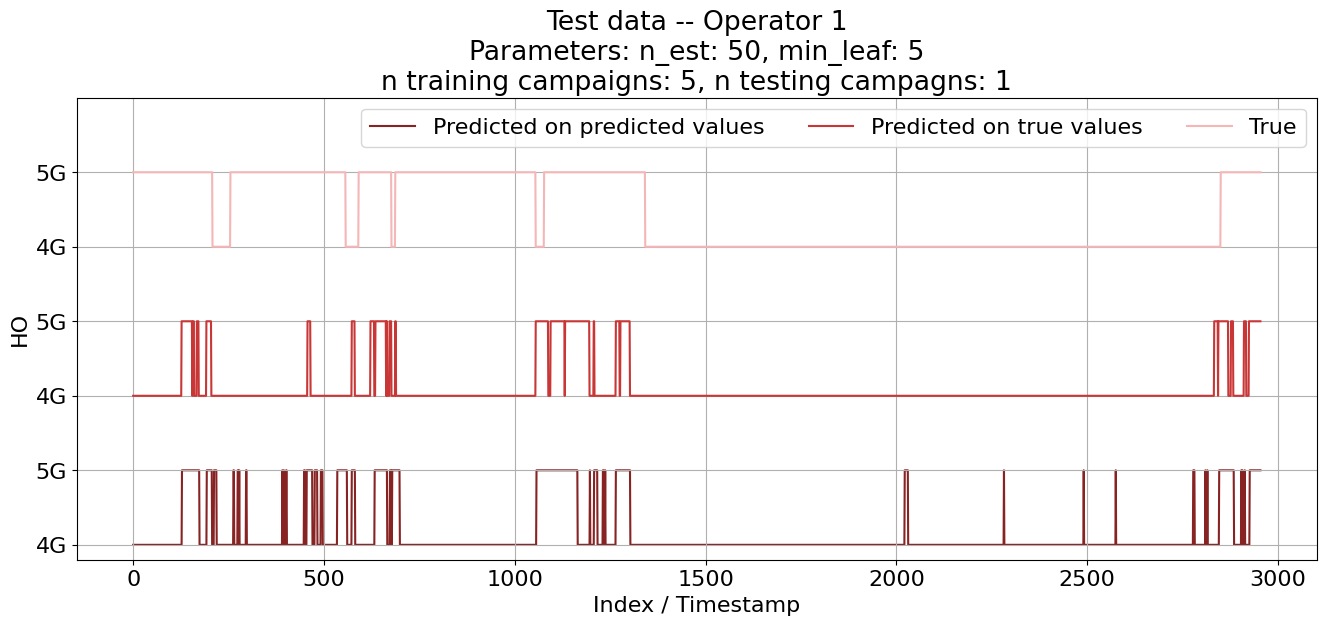

In [143]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

#### 5 steps ahead

In [144]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')
df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00636,0.00320,1.82,2.13
1,"RSRP, SINR, RSRQ -> RSRP",0.00340,0.00276,1.31,1.79
2,"RSRP, SSS_RSRP -> RSRP",0.00322,0.00172,0.87,1.17
3,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00344,0.01171,4.82,4.61
4,SINR -> SINR,0.00337,0.00420,2.01,2.75
5,"RSRP, SINR, RSRQ -> SINR",0.00310,0.00570,2.77,3.59
6,"SINR, SSS_SINR -> SINR",0.00231,0.00296,1.84,2.32
7,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00230,0.00310,1.79,2.26
8,RSRQ -> RSRQ,0.00759,0.00527,0.49,0.63
9,"RSRP, SINR, RSRQ -> RSRQ",0.00863,0.00865,1.38,1.45


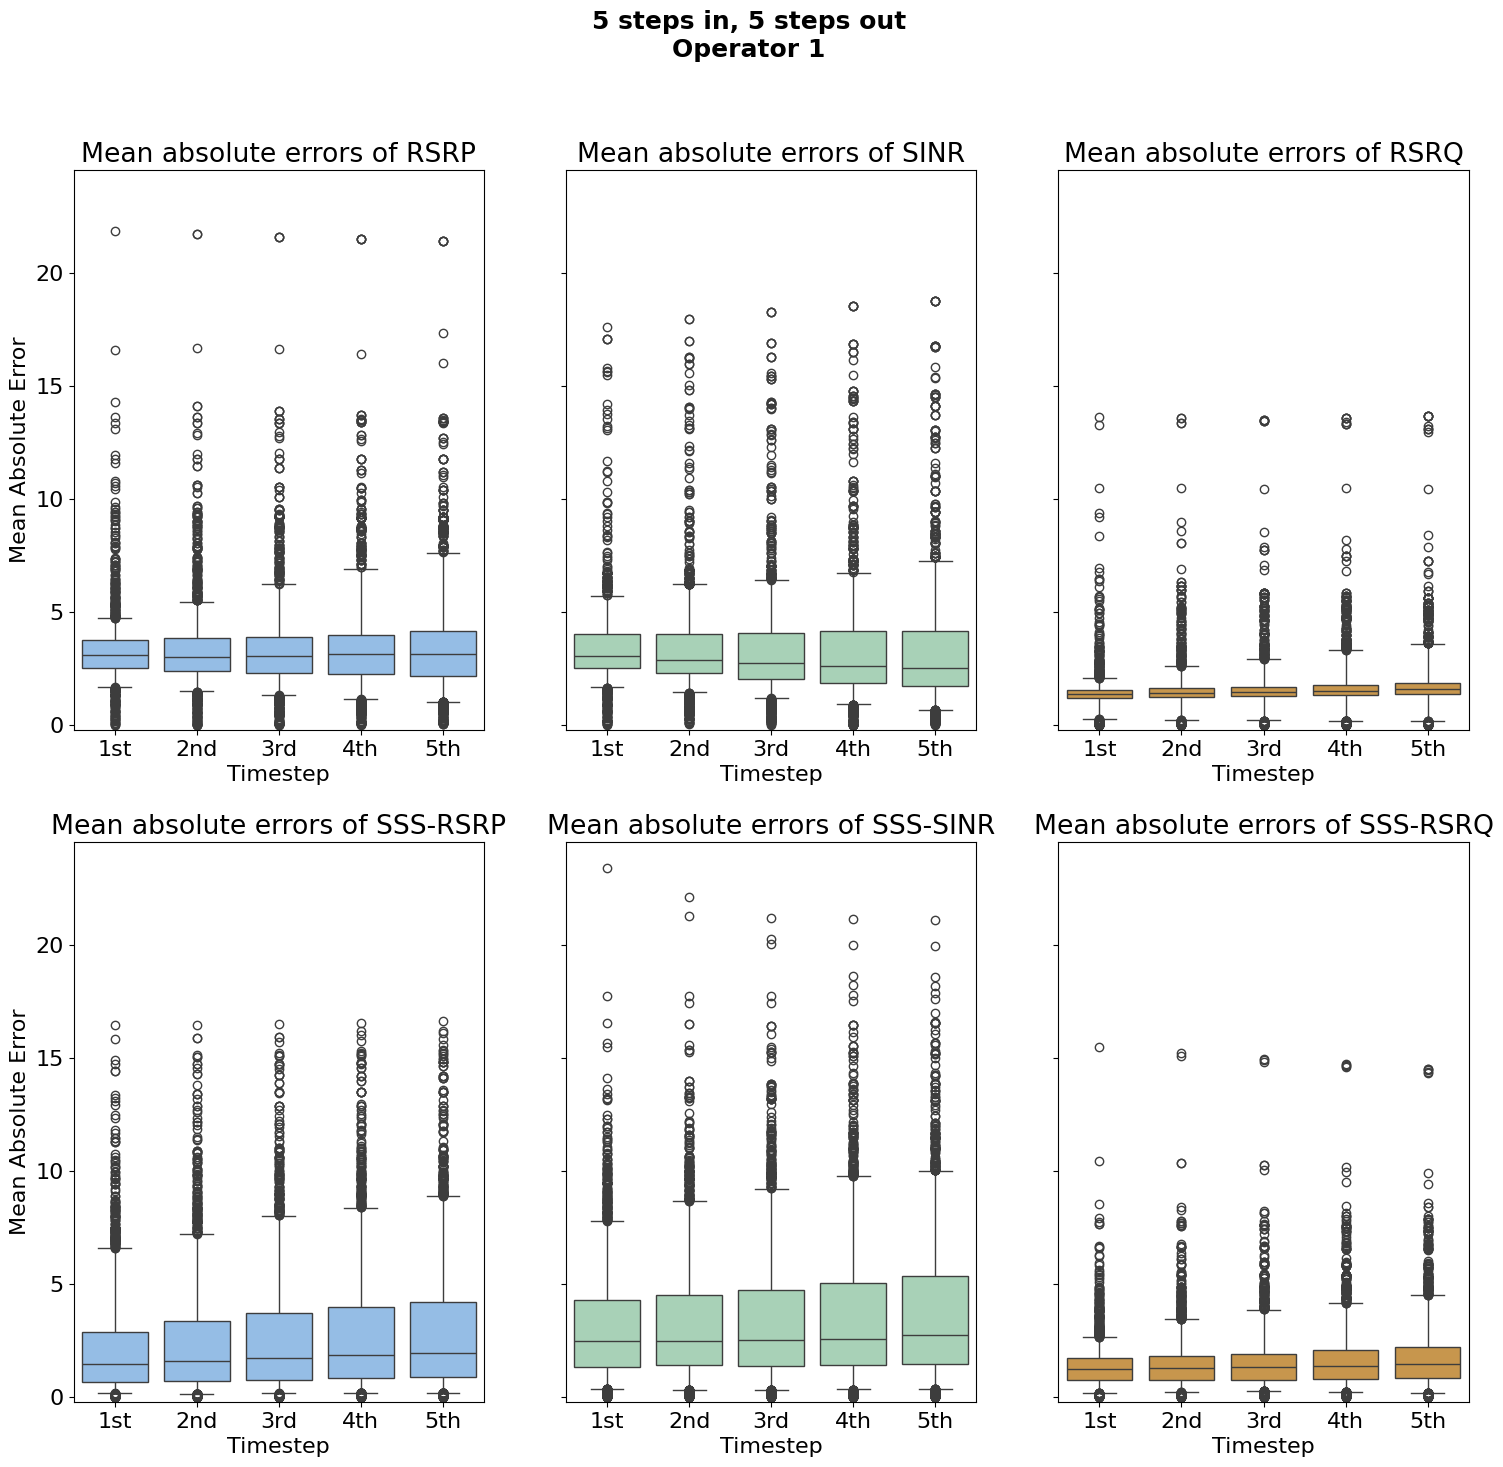

In [145]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op1_box_5_steps_mae_lstm_60_clusters.pdf')

In [146]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [147]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.640,0.830,0.251,0.998,0.993,0.996,0.618,0.177,0.877,0.816,0.365,0.671,"[0.6390773405698779, 0.6394165535956581, 0.639...","[0.997582316371172, 0.997582316371172, 0.99758..."
1,"n_est: 5, min_leaf: 5",0.675,0.852,0.335,0.994,0.980,0.995,0.602,0.159,0.786,0.823,0.431,0.668,"[0.6743554952510177, 0.6743554952510177, 0.674...","[0.9943587381994013, 0.9943587381994013, 0.994..."
2,"n_est: 5, min_leaf: 10",0.638,0.833,0.244,0.989,0.957,0.995,0.625,0.204,0.847,0.831,0.467,0.687,"[0.6370420624151968, 0.6373812754409769, 0.637...","[0.9889477319825005, 0.9889477319825005, 0.988..."
3,"n_est: 5, min_leaf: 15",0.621,0.740,0.245,0.984,0.947,0.984,0.611,0.183,0.795,0.811,0.419,0.623,"[0.6207598371777476, 0.6210990502035278, 0.621...","[0.9838821091411467, 0.9838821091411467, 0.983..."
4,"n_est: 10, min_leaf: 1",0.609,0.810,0.170,0.998,0.993,0.997,0.584,0.105,0.783,0.831,0.404,0.729,"[0.6078697421981004, 0.6082089552238806, 0.608...","[0.997697444163021, 0.997697444163021, 0.99769..."
5,"n_est: 10, min_leaf: 5",0.616,0.741,0.225,0.994,0.980,0.994,0.588,0.125,0.753,0.841,0.519,0.699,"[0.6149932157394844, 0.6153324287652646, 0.615...","[0.9941284826157034, 0.9941284826157034, 0.994..."
6,"n_est: 10, min_leaf: 10",0.631,0.795,0.242,0.987,0.951,0.995,0.593,0.131,0.794,0.843,0.559,0.688,"[0.6299185888738128, 0.6302578018995929, 0.630...","[0.9874510706884642, 0.9874510706884642, 0.987..."
7,"n_est: 10, min_leaf: 15",0.688,0.886,0.352,0.980,0.928,0.990,0.602,0.173,0.754,0.861,0.617,0.728,"[0.6872455902306649, 0.687584803256445, 0.6879...","[0.9804282753856781, 0.9804282753856781, 0.980..."
8,"n_est: 50, min_leaf: 1",0.614,0.808,0.188,0.998,0.994,0.997,0.594,0.134,0.785,0.866,0.566,0.783,"[0.6136363636363636, 0.6139755766621439, 0.614...","[0.9979276997467189, 0.9979276997467189, 0.997..."
9,"n_est: 50, min_leaf: 5",0.634,0.852,0.226,0.996,0.986,0.997,0.585,0.105,0.790,0.851,0.522,0.745,"[0.6333107191316146, 0.6336499321573948, 0.633...","[0.9960856550771356, 0.9960856550771356, 0.996..."


In [149]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.634
Mean precision: 0.834
Mean recall: 0.234


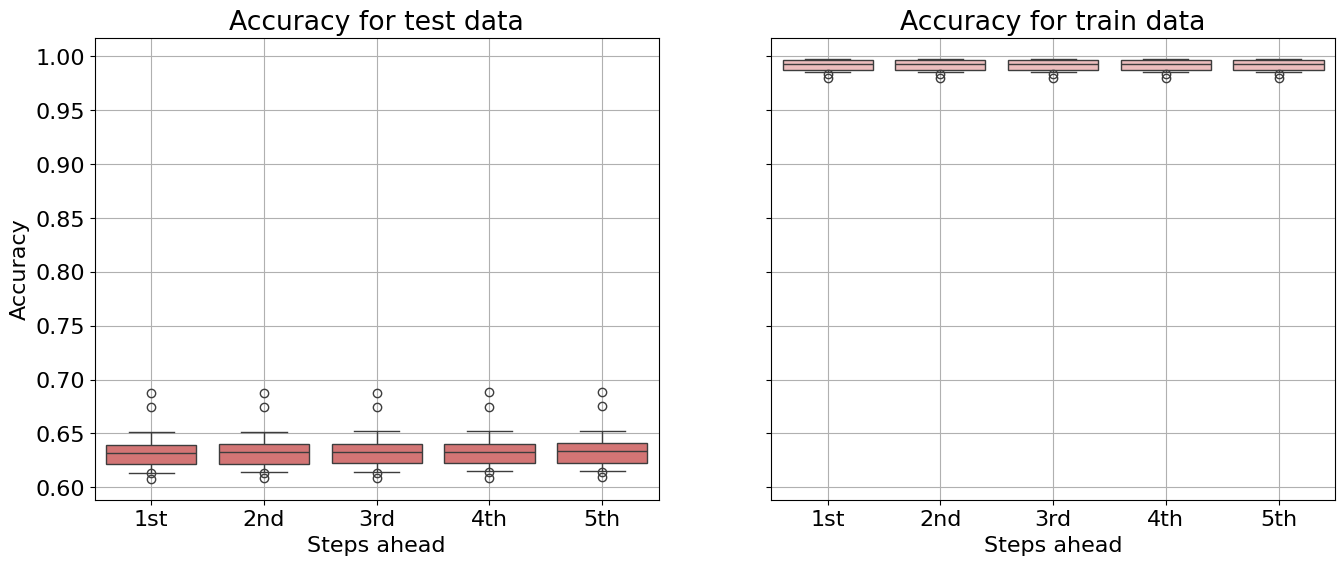

In [148]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/rf_loc/op1_boxplot_5_steps_60_clusters.pdf')